In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture as GMM

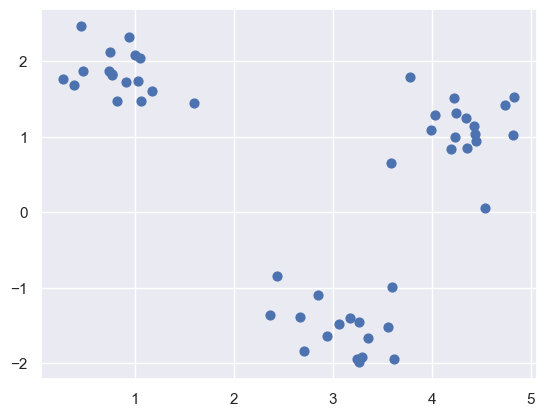

In [166]:
# Generate data
X, y_true = make_blobs(n_samples=50, centers=3,
                       cluster_std=0.36, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');

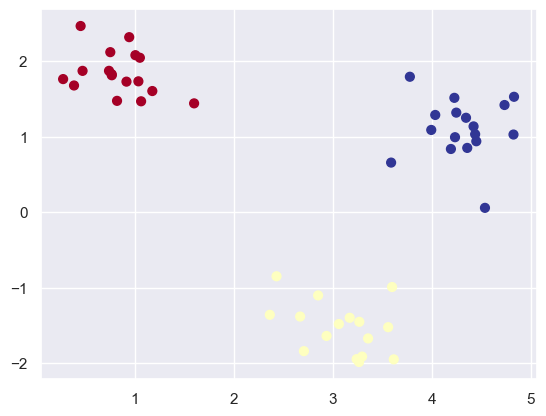

In [167]:
# Plot the data with K Means
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='RdYlBu');

In [312]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

In [313]:
rng = np.random.RandomState(0)
x_rnd = rng.randn(2, 2)
X_stretched = np.dot(X, x_rnd)

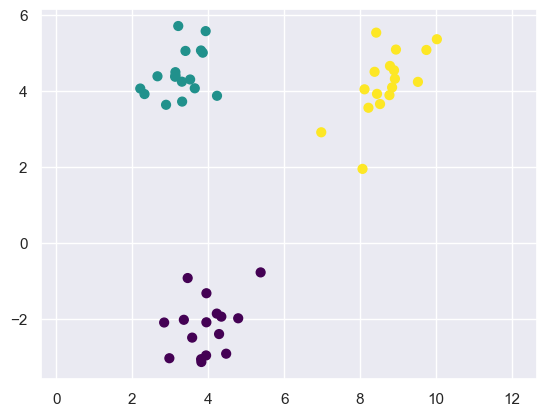

In [314]:
kmeans = KMeans(n_clusters=3, random_state=7)
plot_kmeans(kmeans, X_stretched)

In [317]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

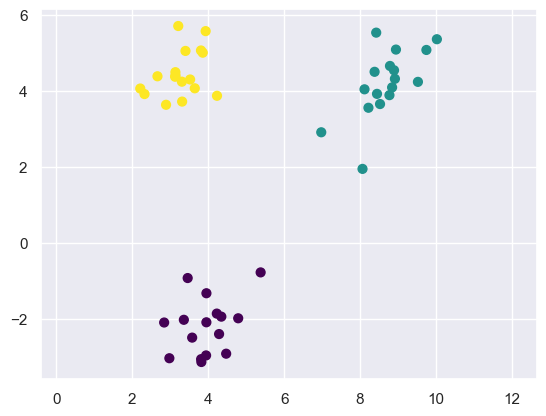

In [318]:
gmm_stretched = GMM(n_components=3)
plot_gmm(gmm_stretched, X_stretched)

In [239]:
class GMM_SA:
    def __init__(self, n_components = 3, max_iter = 100):
        self.K_classes = n_components
        self.max_iter = max_iter
        self.labels = np.arange(n_components)
        self.pi = np.ones(n_components)*(1./n_components)

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        return np.power(np.sqrt(np.power(2.0 * np.pi, len(X))) * np.sqrt(np.linalg.det(covariance_matrix)),  -1) * np.exp((1./2.)*-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector)))
    
    def all_sum_joint_proba(self, X_n):
        return np.sum([self.pi[j]*self.multivariate_normal(X_n, self.mu[j], self.sigma[j]) for j in range(self.K_classes)])
    
    def fit(self, X):
        # Random Initialization Step
        K = self.K_classes
        rows, cols = X.shape
        if(rows > 10000):
            split_set_size = np.int_(np.floor(rows/K)/2) # Handle for high dimensions 
        else:
            split_set_size = np.int_(np.floor(rows/K))
        size = np.int_(split_set_size*K)
        row_indexes = np.random.randint(low=0, high=rows, size=size).reshape((K, split_set_size))        
        self.mu = [np.mean(X[row_indexes[i]], axis=0) for i in range(K)]
        self.sigma = [np.cov(X[row_indexes[i]].T) for i in range(K)]

        for iteration in range(self.max_iter):
            # E - Step
            # Calculating Gammas
            self.gammas = np.zeros((rows, K))
            for n in range(rows):
                all_sum_prob = self.all_sum_joint_proba(X[n])
                for k in range(self.K_classes):
                    self.gammas[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mu[k], self.sigma[k])
                    self.gammas[n][k] /= all_sum_prob
            # M - Step      
            # Calculating N        
            N = np.sum(self.gammas, axis=0)
            # Updating Mean vector
            self.mu = np.zeros((K, cols)) # reset
            for k in range(self.K_classes):
                for n in range(len(X)):
                    self.mu[k] += self.gammas[n][k] * X[n]
            self.mu = [1/N[k]*self.mu[k] for k in range(self.K_classes)]
            # Updating Sigma matrix
            self.sigma = [np.zeros((cols, cols)) for k in range(self.K_classes)] # reset
            for k in range(self.K_classes):
                self.sigma[k] = np.cov((X-self.mu[k]).T, aweights=(self.gammas[:, k]), ddof=0)
            self.sigma = [1/N[k]*self.sigma[k] for k in range(K)]
            # Updating Pi vector
            self.pi = [N[k]/rows for k in range(K)]
        
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mu[k], self.sigma[k])
                           for k in range(self.K_classes)])
        classes = []
        for proba in probas:
            classes.append(self.labels[proba.index(max(proba))])
        return classes
    

In [189]:
def get_labels(gmm_model):
    gmm_model.fit(X)
    labels = gmm_model.predict(X)
    return labels

In [249]:
def plot_gmm_custom(gmm_model, X, labels, cmap='viridis'):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')

In [299]:
gmm_sa = GMM_SA(n_components=3, max_iter=3)

In [300]:
labels = get_labels(gmm_sa)
print(labels)
print(len(labels))

[1, 0, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 1, 0, 2, 1, 1]
50


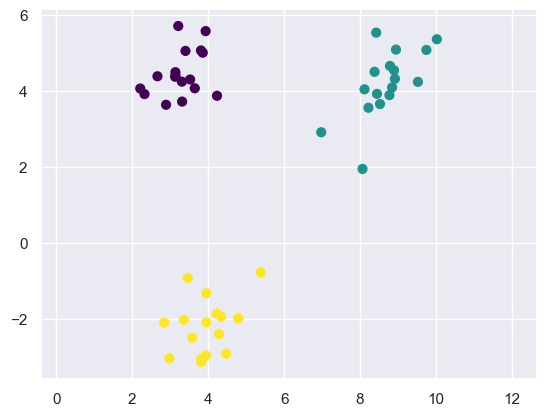

In [301]:
plot_gmm_custom(gmm_sa, X_stretched, labels)

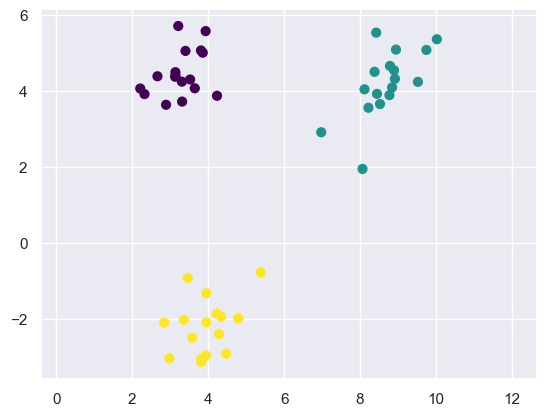

In [311]:
plot_gmm_(gmm_stretched, X_stretched)